In [1]:
from specio import specread
import re
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from Chemometrics.data_io import read_dx
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from Chemometrics.basic import psave, pload
from sklearn.metrics import roc_curve, accuracy_score, classification_report
import seaborn as sns
from Chemometrics.basic import plot_cm, plot_ConfusionMatrix
from sklearn.metrics import confusion_matrix
import gc

%matplotlib inline
plt.rcParams['font.sans-serif'] = 'SimHei'

In [2]:
data_filepath = "C://Users//litao//Desktop//党参红外产地区分"

In [3]:
allfiles = glob(data_filepath+'/**/*.JDX')

In [4]:
file = allfiles[0]
file

'C://Users//litao//Desktop//党参红外产地区分\\凉州区\\ds-035-1-1.JDX'

In [5]:
def get_loc(file):
    """
    从file中读取产地信息
    file: str, e.g., 'C://Users//litao//Desktop//党参红外产地区分\\凉州区\\ds-035-1-1.sp'
    return: str, e.g., '凉州区'
    """
    reg_str = '(?<=党参红外产地区分\\\).*(?=\\\)'
    location = re.search(reg_str, file)[0]
    return location

In [6]:
def get_tag(file):
    reg_str = 'ds.*?(?=\.JDX)'
    tag = re.search(reg_str, file)
    if tag:
        return tag[0]
    else:
        return file

In [7]:
def sample_tag(tag):
    reg_str = 'ds-[0-9]+-[0-9]+'
    sample_t = re.search(reg_str, tag)
    if sample_t:
        return sample_t[0]

In [13]:
tags = [get_tag(file) for file in allfiles]
sample_tags = [sample_tag(tag) for tag in tags]

In [8]:
#regex lookahead(x) (?=x)
#      lookbehind(x) (?<=x)
locs = [get_loc(file) for file in allfiles]
locs[0]

'凉州区'

In [9]:
a = [read_dx(file) for file in allfiles]

In [10]:
b = np.vstack(s.values for s in a)

In [11]:
b.shape, len(a)

((1045, 1867), 1045)

In [41]:
b_ = pd.DataFrame(b, index=sample_tags, columns=read_dx(file).index)
_y = pd.Series(locs, index=b_.index)
#去掉异常样本
mask = (b_>20).any(axis=1)
X_ = b_.loc[~mask,:]
y = _y.loc[~mask]

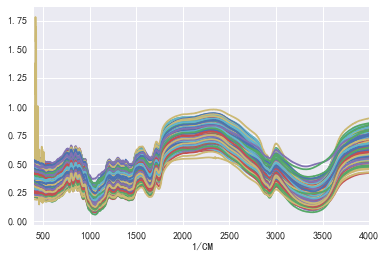

In [42]:
X_.T.plot(legend=False)

In [17]:
X_.shape

(1043, 1867)

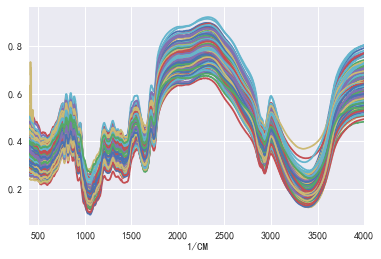

In [43]:
#平均
plt.figure(figsize=(10,5))
X = X_.groupby(X_.index).mean()
y_ = y.groupby(y.index).first()
X.T.plot(legend=False)

In [20]:
le = LabelEncoder()
y = le.fit_transform(y_)

In [21]:
psave(dict(X=X, y=y), '整理后原始数据Xy.p')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [23]:
X.shape

(320, 1867)

In [28]:
import seaborn as sns

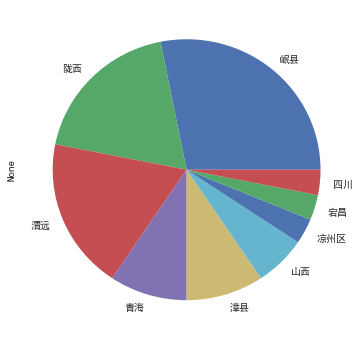

In [39]:
y_.value_counts().plot(kind='pie', figsize=(6,6))
plt.savefig('党参产地.png', dpi=600)

In [46]:
y_.value_counts().to_excel('党参产地.xlsx')

In [94]:
y.unique()

array(['凉州区', '四川', '宕昌', '山西', '岷县', '渭远', '漳县', '陇西', '青海'],
      dtype=object)

这个分布和产地真是分布是不一样的

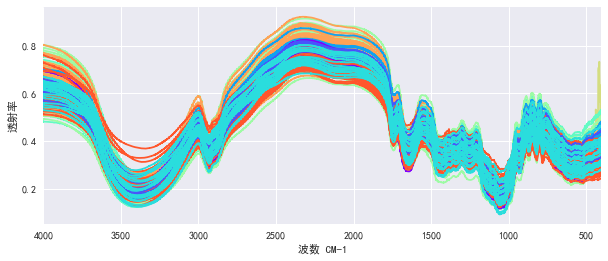

In [106]:
_xx = X.loc[:, X.columns.sort_values(ascending=False)]
plt.figure(figsize=(10,4))
ax = plt.axes()
for loc in y_.unique():
    xx_ = _xx.loc[y_ == loc,:]
    xx_.T.plot(legend=False, ax=ax, color=plt.cm.rainbow(le.transform([loc])/9), label=loc)
plt.xlabel('波数 CM-1')
plt.ylabel('透射率')
plt.savefig('党参红外光谱.png',dpi=600)

In [105]:
#预处理

In [19]:
from Chemometrics.spectra_utils import first_derivative, SNV

In [20]:
X_SNV = SNV(X.values)
X_1d_snv = first_derivative(X_SNV)

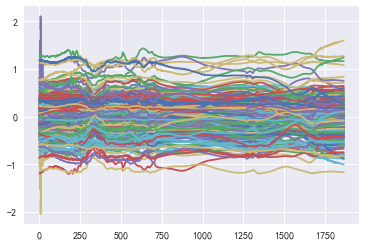

In [35]:
lines = plt.plot(X_1d_snv)
#todo 平滑

In [ ]:
X_1d_snv.shape

In [40]:
#(X_1d_snv - (X_1d_snv.std(axis=0)*3)[np.newaxis, :])
#todo 异常值

# baseline: LR
输入:原始光谱数据

In [75]:
lr = LogisticRegression(random_state=1)
params = dict(C=np.logspace(2, 5, num=5))
grid_lr = GridSearchCV(lr, param_grid=params, n_jobs=-1)
grid_lr.fit(X_train, y_train)
best_model = grid_lr.best_estimator_
ytestpred_train = cross_val_predict(best_model, X_train, y_train)
psave(best_model, 'LR_model.p')

最大test score为 92.92%


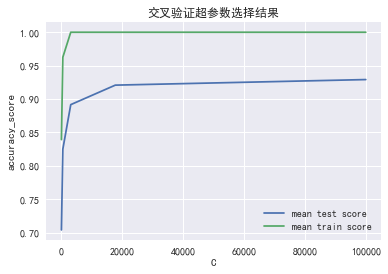

In [67]:
cv_results = pd.DataFrame(dict(grid_lr.cv_results_))
c = cv_results.param_C
plt.plot(c, cv_results.mean_test_score, label='mean test score')
plt.plot(c, cv_results.mean_train_score, label='mean train score')
plt.legend()
plt.title('交叉验证超参数选择结果')
plt.xlabel('C')
plt.ylabel('accuracy_score')
print('最大test score为 {}%'.format(round(cv_results.mean_test_score.max()*100, 2)))

             precision    recall  f1-score   support

          0       0.60      1.00      0.75         6
          1       1.00      1.00      1.00         8
          2       1.00      1.00      1.00        10
          3       1.00      0.79      0.88        14
          4       0.93      0.94      0.93        68
          5       0.93      0.91      0.92        45
          6       0.88      0.78      0.82        18
          7       0.94      0.98      0.96        45
          8       1.00      0.96      0.98        26

avg / total       0.94      0.93      0.93       240



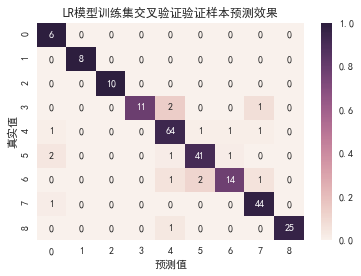

In [84]:
cm_lr = confusion_matrix(y_train, ytestpred_train)
plot_ConfusionMatrix(cm_lr)
plt.title('LR模型训练集交叉验证验证样本预测效果')
print(classification_report(y_train, ytestpred_train))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         4
          1       1.00      1.00      1.00         2
          3       1.00      0.67      0.80         6
          4       0.96      1.00      0.98        22
          5       1.00      1.00      1.00        15
          6       1.00      0.92      0.96        12
          7       0.94      1.00      0.97        15
          8       0.80      1.00      0.89         4

avg / total       0.97      0.96      0.96        80



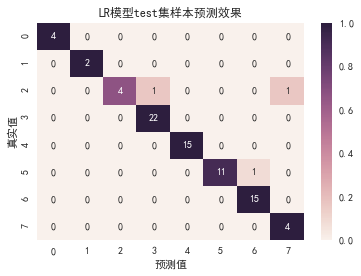

In [83]:
#test集预测效果
yhat_test = best_model.predict(X_test)
cm_test_lr = confusion_matrix(y_test, yhat_test)
plot_ConfusionMatrix(cm_test_lr)
plt.title('LR模型test集样本预测效果')
print(classification_report(y_test, yhat_test))

# test1: gradient boosting machine
输入原始数据

In [25]:
gbm = GradientBoostingClassifier(learning_rate=.1,
             n_estimators = range(100, 200, 10),
             subsample=.8,
             min_samples_split=2,
             min_samples_leaf=5,
             max_depth=3,
             random_state=1,
             max_features=.8)
parameters = dict(n_estimators = range(100, 200, 10))
grid = GridSearchCV(gbm, param_grid=parameters, n_jobs=-1)

1. todo lightgbm
2. todo feature selection #features 太多了

In [28]:
# psave(grid, 'gbm-grid.p')
grid = pload('gbm-grid.p')

最大test score为0.48


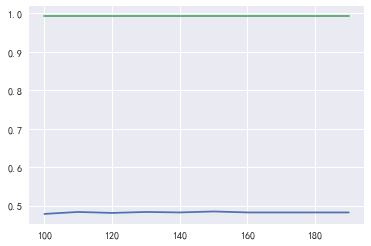

In [91]:
# 训练过程
cv_results = pd.DataFrame(dict(grid.cv_results_))
n_estimators = cv_results.param_n_estimators
plt.plot(n_estimators, cv_results.mean_test_score)
plt.plot(n_estimators, cv_results.mean_train_score)
#train test gap 很大存在过拟合
print('最大test score为{}'.format(np.round(cv_results.mean_test_score.max(), 2)))

In [34]:
yhat_train = grid.predict(X_train)
y_cvtest_train = cross_val_predict(grid.best_estimator_, X_train, y_train)
cm_cvtest = confusion_matrix(y_train, y_cvtest_train)
plot_ConfusionMatrix(cm_cvtest)